# DTSA 5509 - Final Project - Credit Card Fraud Detection

https://github.com/rickgarcia/DTSA5509

## Project Overview

This project aims to build and test a machine learning model to detect fraudulent credit card transactions from a dataset sourced from Kaggle. Credit card fraud costs financial institutions and consumers billions of dollars annually, making effective fraud detection systems critical for the industry.

Credit card fraud detection presents several distinct challenges:
- **Extreme class imbalance**: Fraudulent transactions typically represent less than 1% of all transactions
- **Cost-sensitive classification**: The cost of missing fraud is typically considerably higher than the cost of investigating a legitimate transaction
- **Requirement for high precision**: False positives create operational costs and customer satisfaction issues

### Goals

* Build an effective fraud detection model that can accurately identify fraudulent transactions while minimizing false positives
* Study and address the class imbalance solutions through sampling techniques
* Optimize the model's performance based on F1 score
* Evaluate model performance using metrics appropriate for imbalanced classification tasks

### Approach

1. Data exploration to understand the dataset's features and distributions
2. Preprocess the data to address issues with class imbalance
3. Train multiple different classification models and evaluate their performance
4. Fine-tune the best model


### Data acquisition and initial exploration

Data sourced from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

`creditcard.csv` file downloaded manually (requires registration w/Kaggle)

In [32]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')


initial data load and data check

In [27]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Examine the data
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(f"Missing values: {df.isnull().sum().sum()}")

# Check the class distribution
print(df['Class'].value_counts())
fraud_percentage = df['Class'].mean() * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

# Exploratory Data Analysis (EDA)


## Initial Data Visualization

In this first visualization stage, we explore the basic distributions of our features and how they differ between fraudulent and legitimate transactions:

- **Feature Histograms**: We've plotted histograms with KDE for each of the anonymized features (V1-V28) to visualize their overall distributions.

- **Time and Amount**: The special histograms for these non-anonymized features show that transaction times are distributed across the dataset period without strong patterns, and that transaction amounts follow a highly skewed distribution, with most transactions being relatively small

- **Class-Based Boxplots**: For each feature, we've created boxplots (0=legitimate, 1=fraudulent) to visualize differences in distributions between the two transaction types. 

These initial visualizations provide our first look into possibel patterns that differentiate fraudulent transactions.

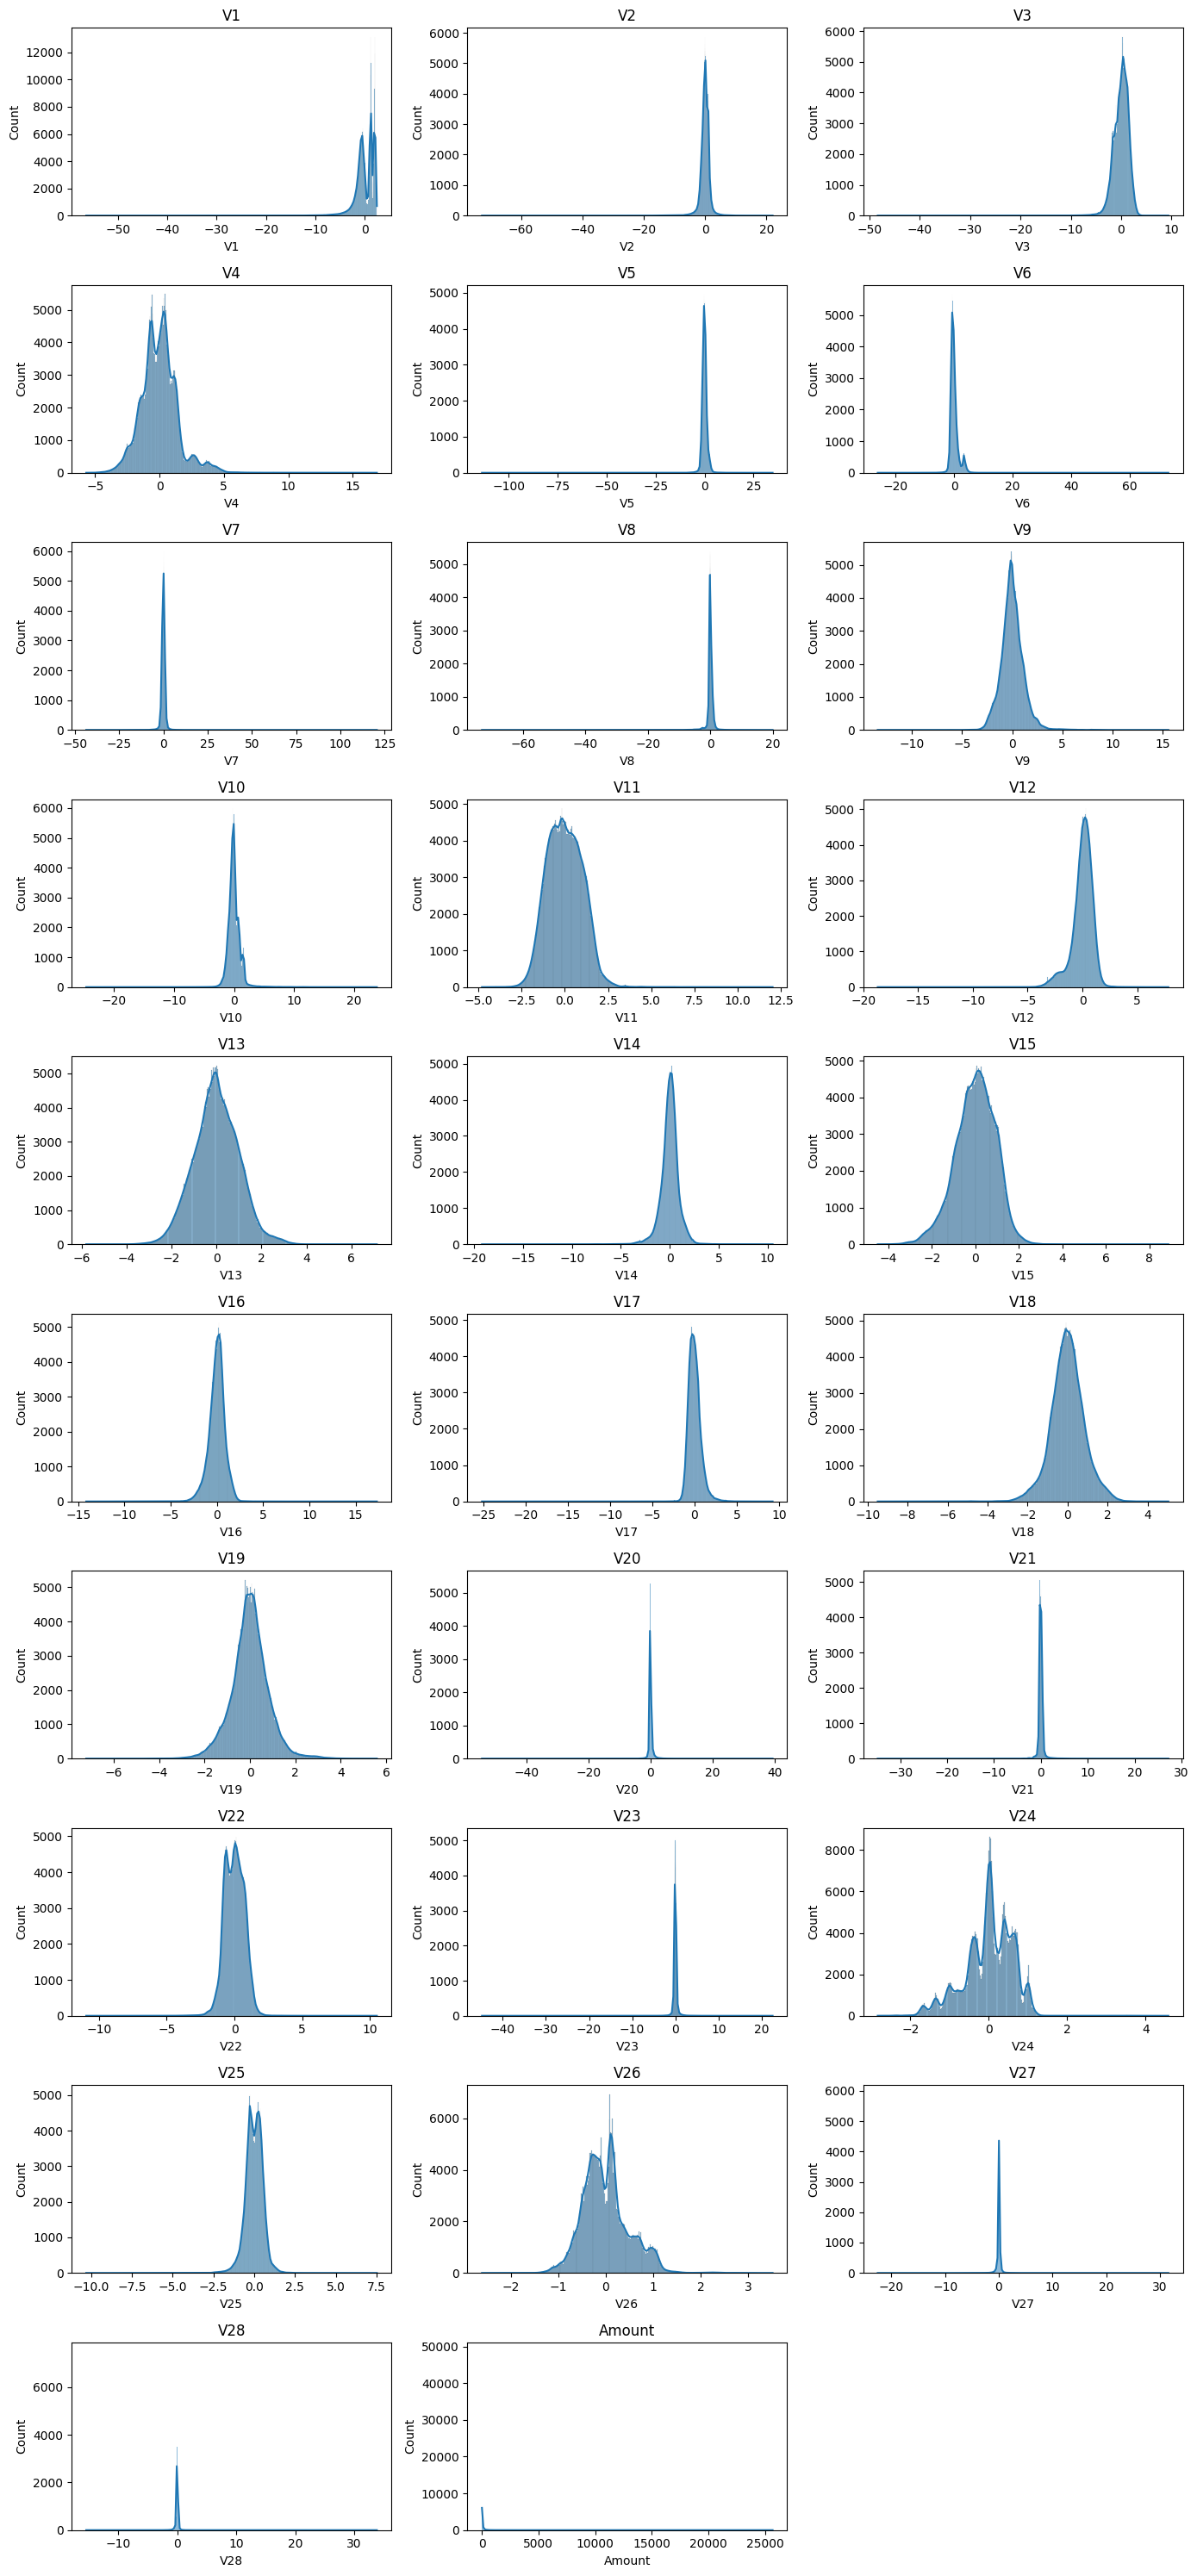

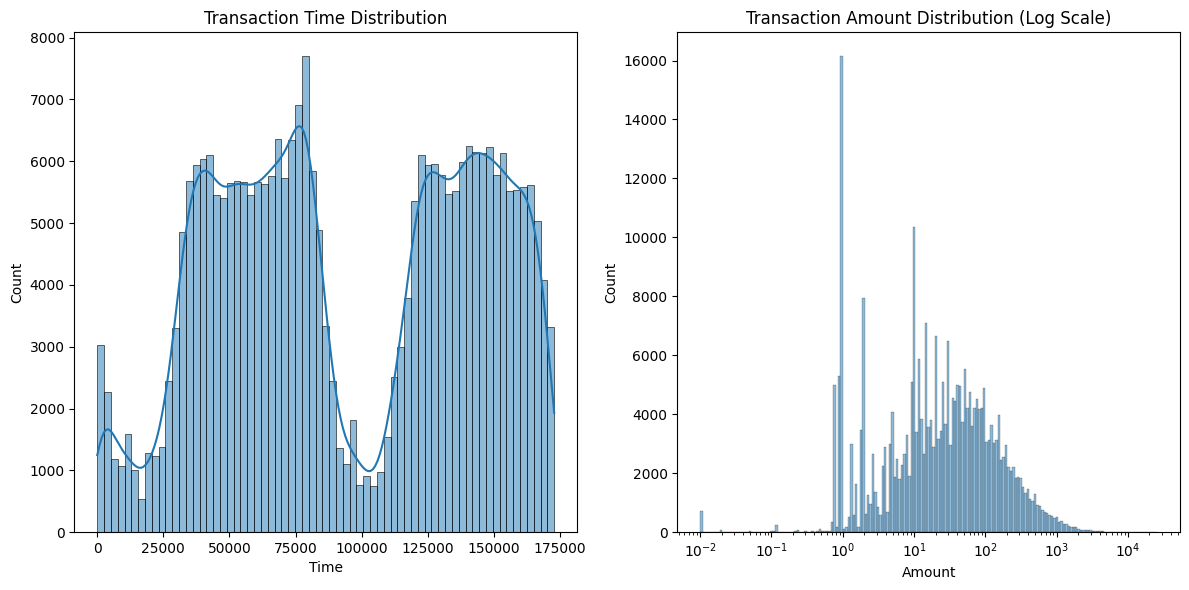

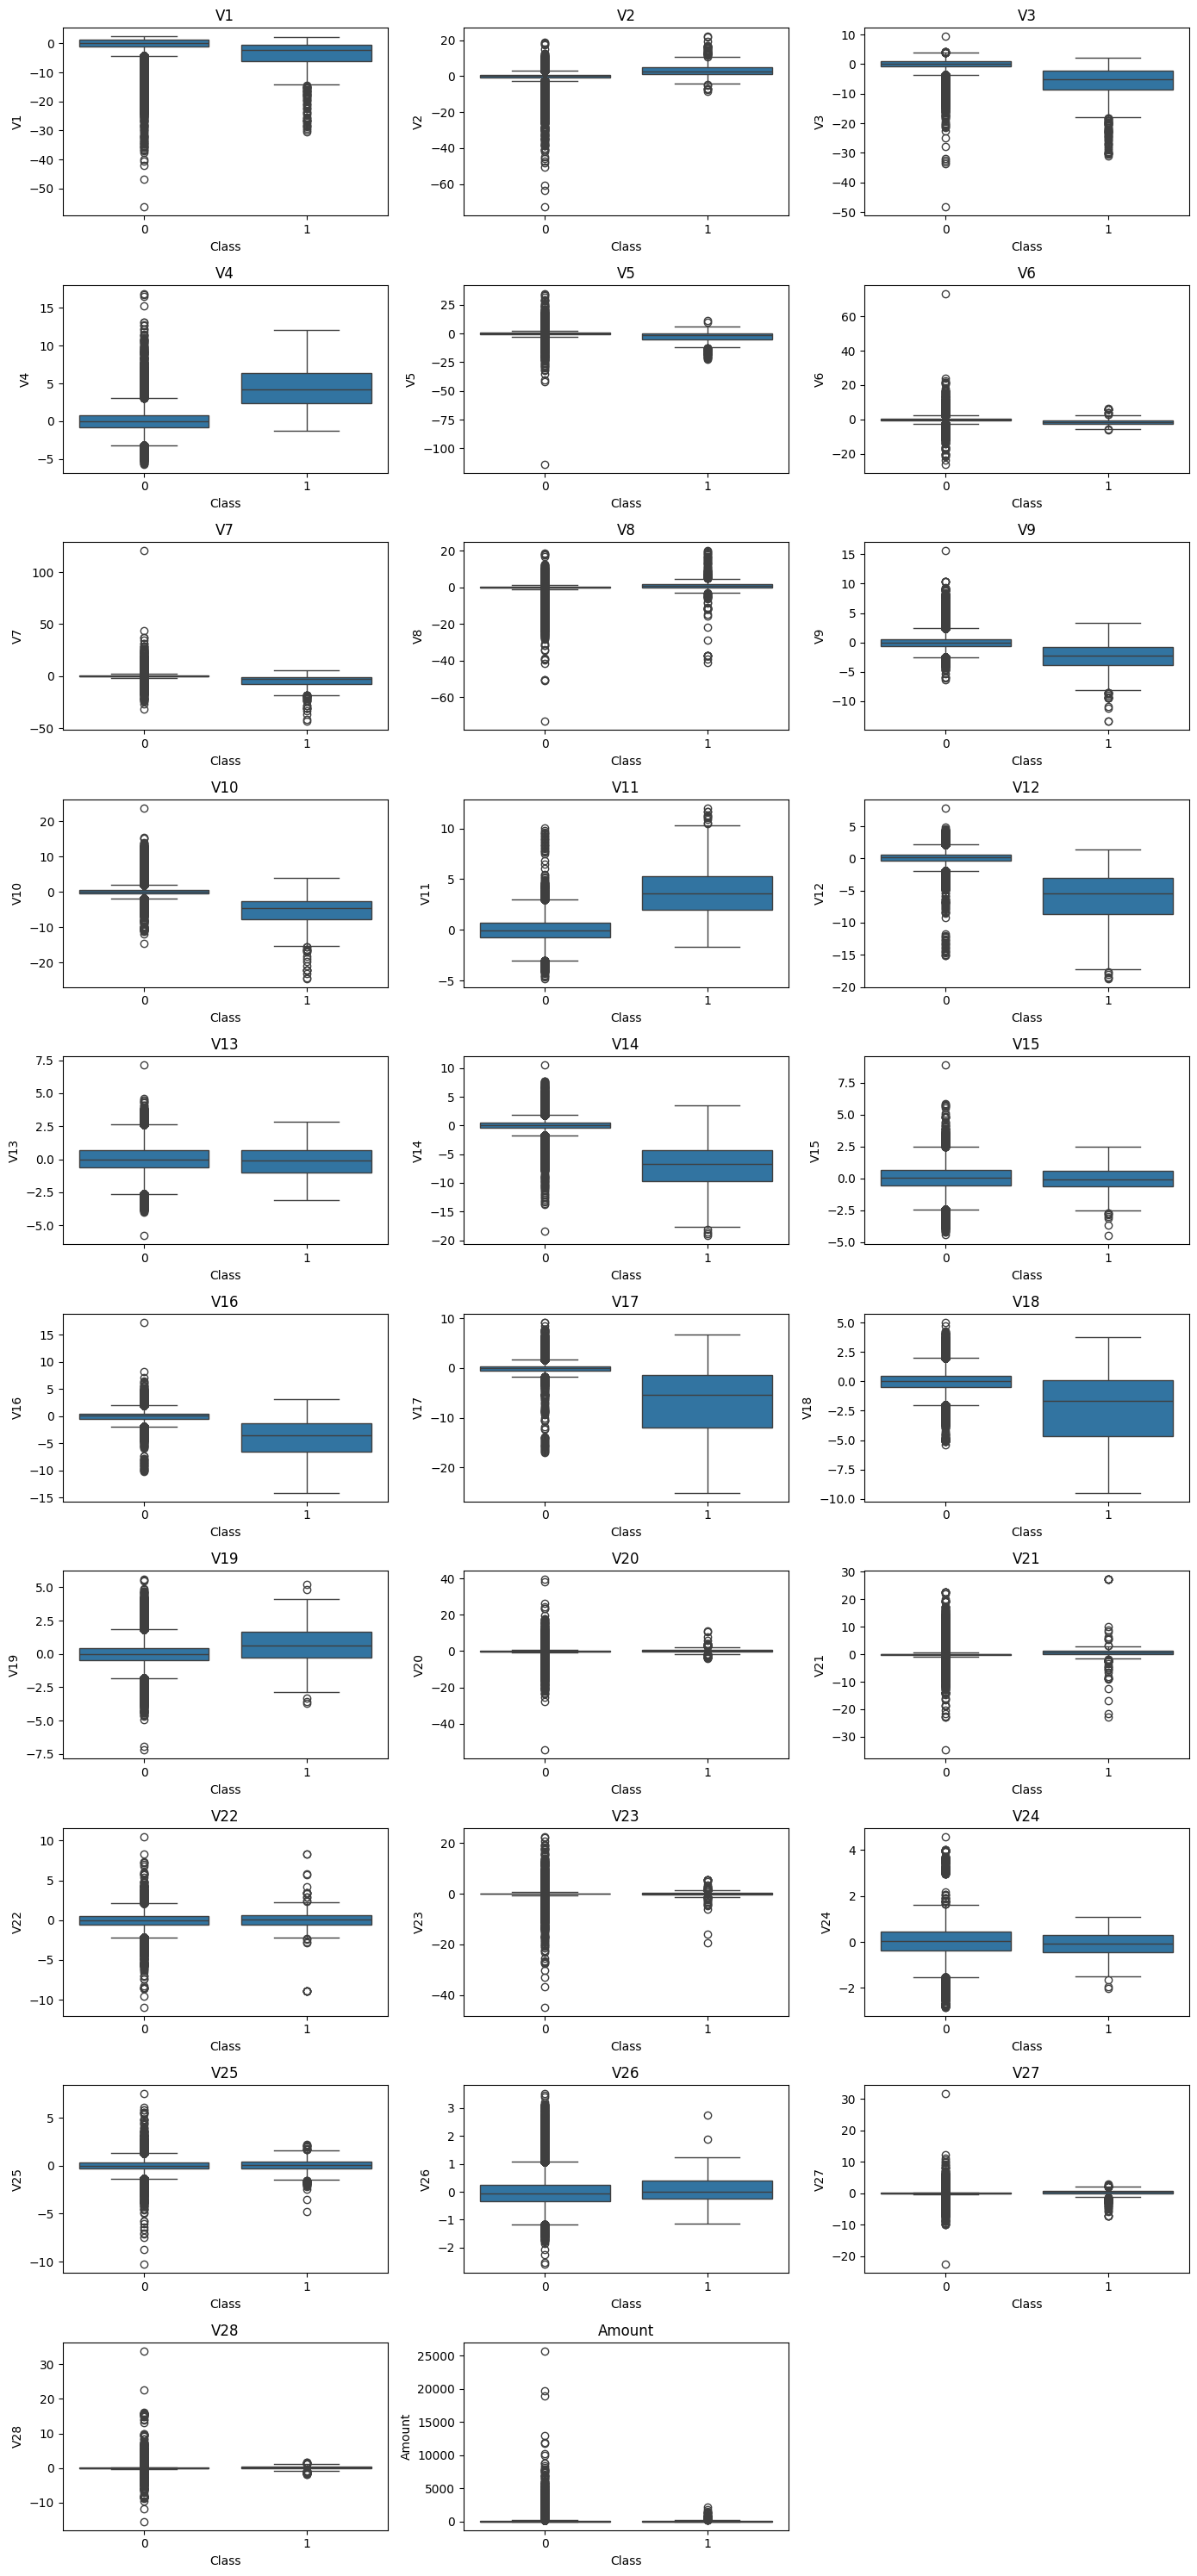

In [31]:
# Distribution of features
plt.figure(figsize=(14, 30))
for i, column in enumerate(df.columns[1:-1]):  # Skip Time and Class
    plt.subplot(10, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Distribution of Time feature
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Time'], kde=True)
plt.title('Transaction Time Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Amount'], kde=True, log_scale=True)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.tight_layout()
plt.show()

# Compare feature distributions for fraudulent vs non-fraudulent transactions
plt.figure(figsize=(14, 30))
for i, column in enumerate(df.columns[1:-1]):  # Skip Time and Class
    plt.subplot(10, 3, i+1)
    sns.boxplot(x='Class', y=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()



### Select Features
These are features where distinction between classes (legitimate 1, fraudulent 0) are readily visible. While there is overlap in each plot due to the class imbalance, these differences in distribution indicate that these specific features may contain signal for classifying transactions.

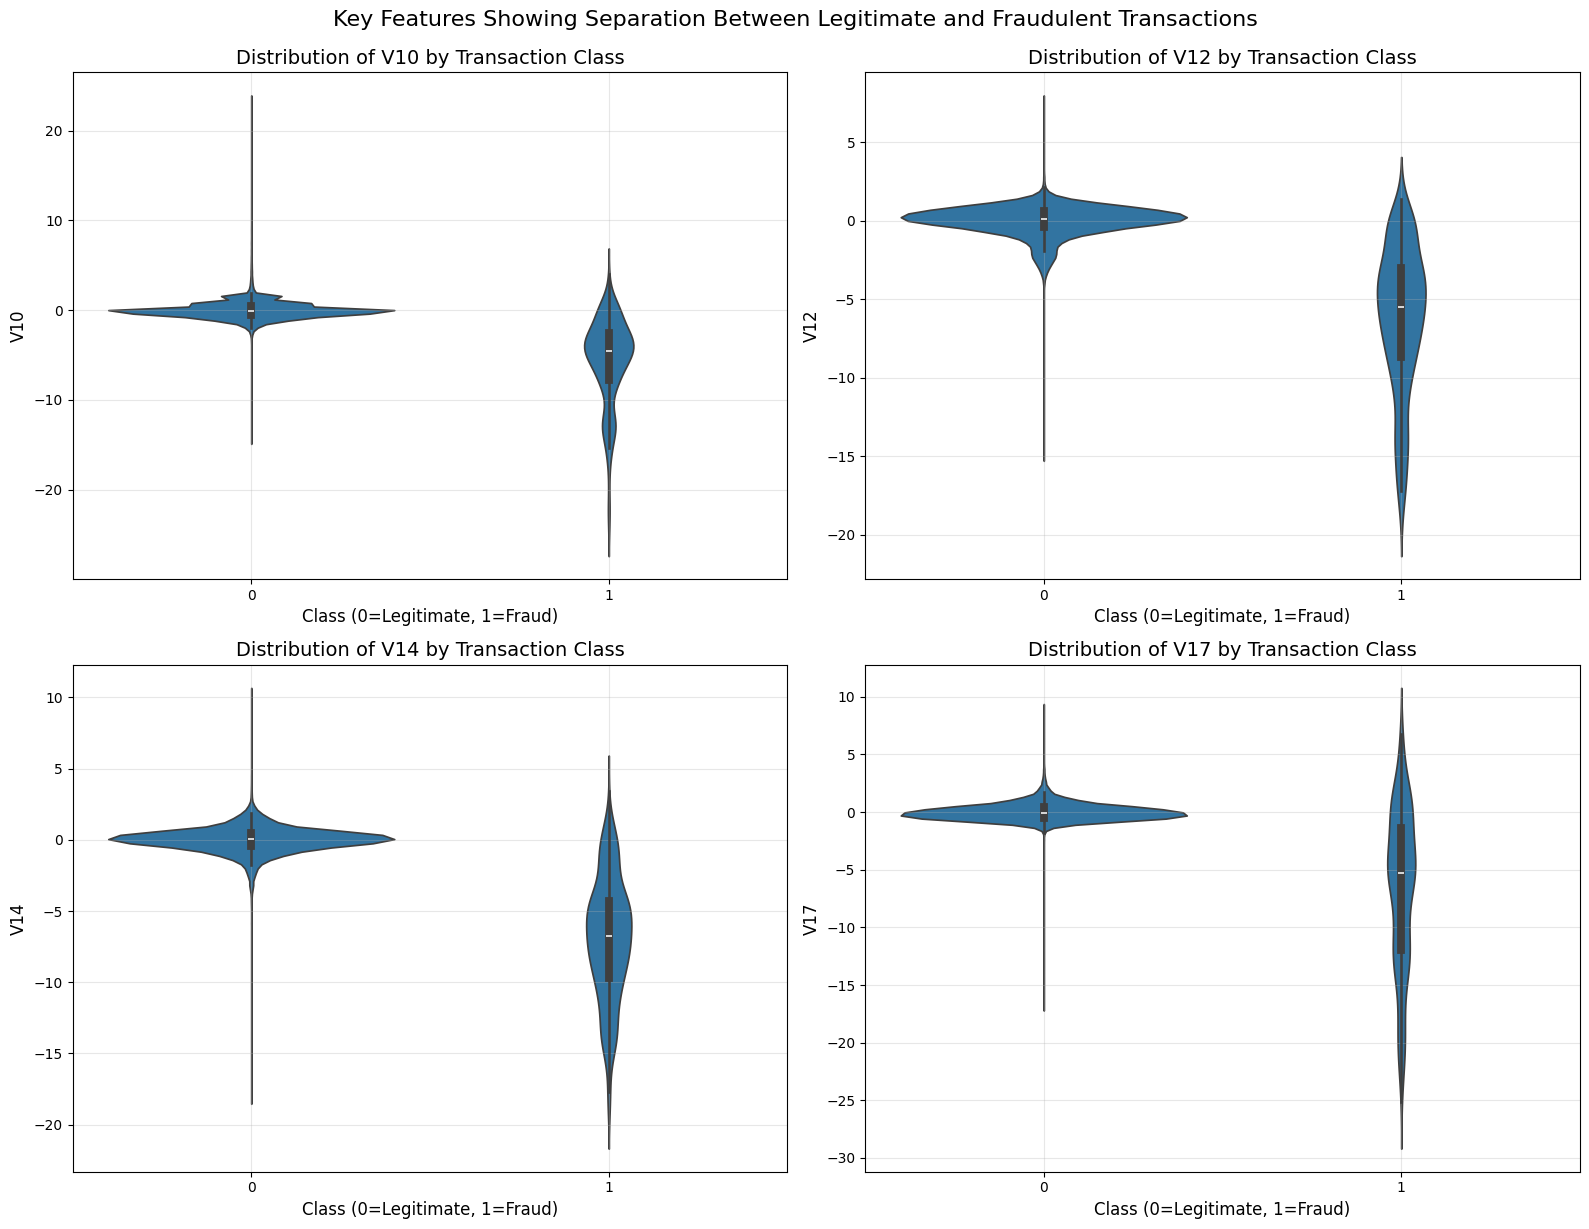

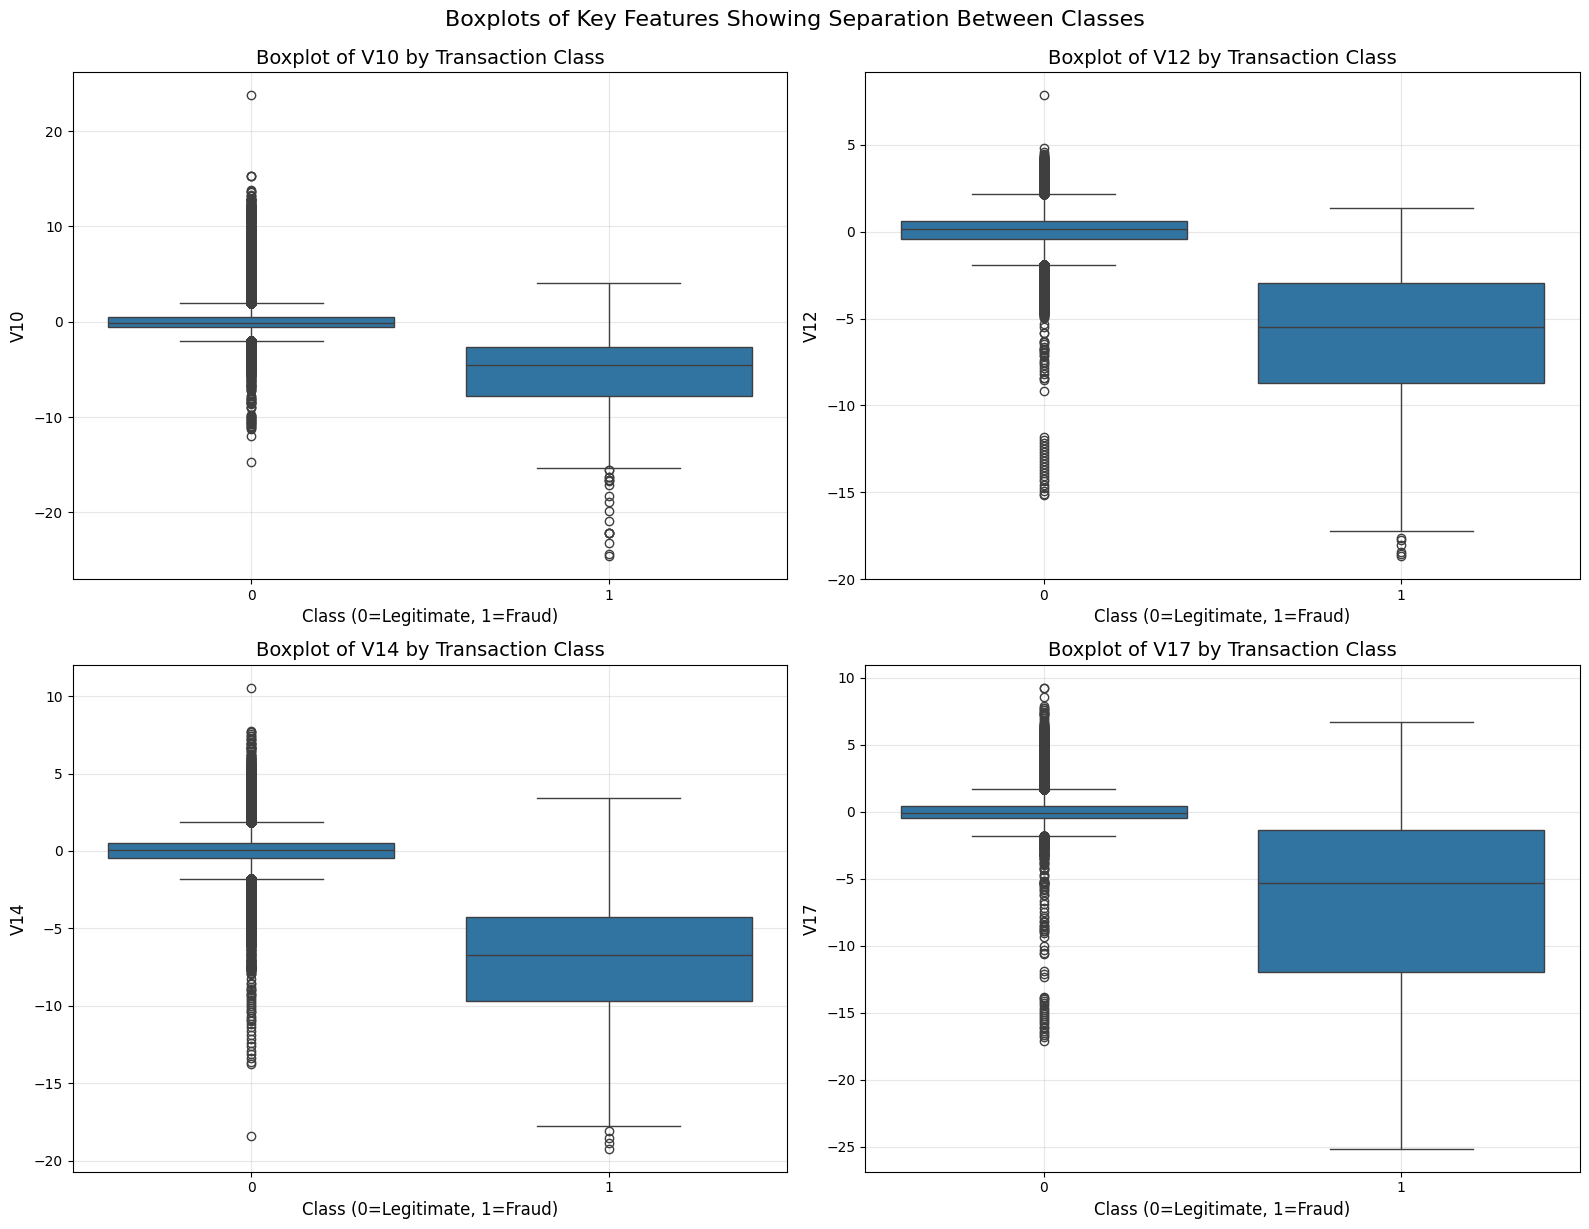

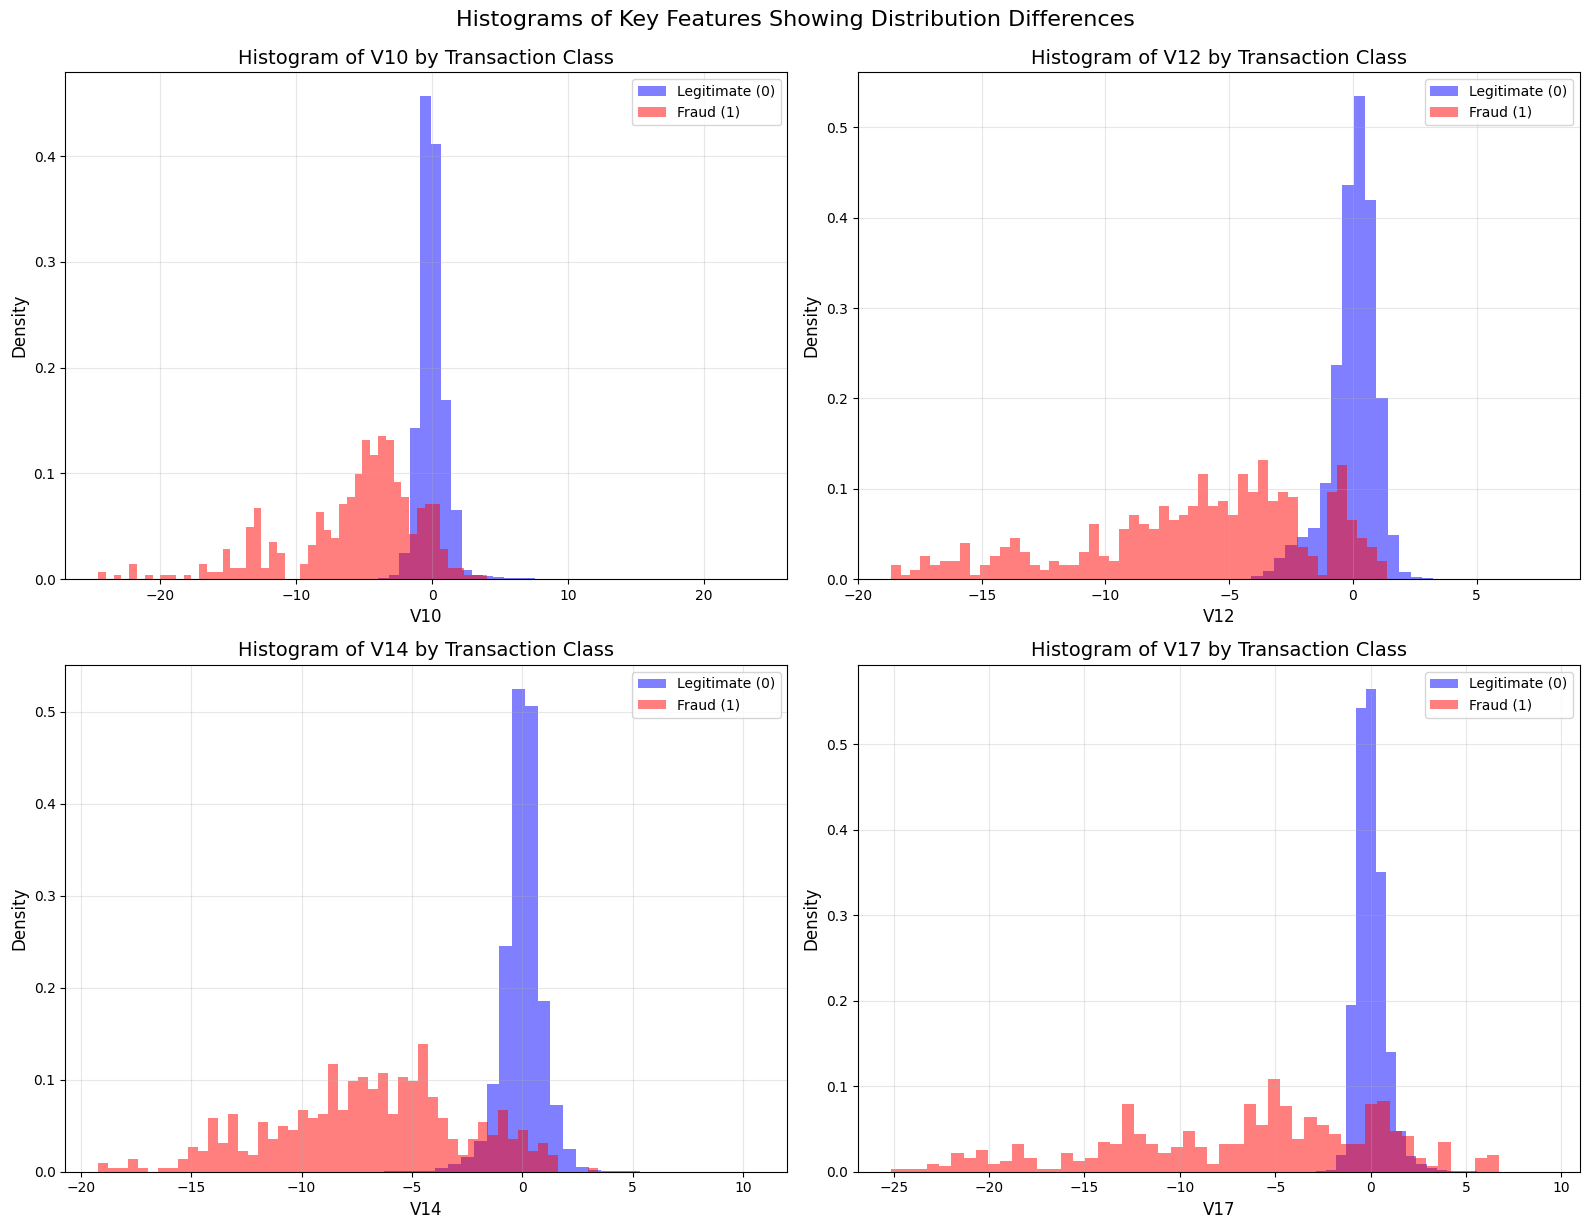

In [28]:

# Set figure size
plt.figure(figsize=(16, 12))

# Selected features that show strong separation between classes
selected_features = ['V10', 'V12', 'V14', 'V17']

# Create subplots for each selected feature
for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    
    # Create violin plots to show distribution by class
    sns.violinplot(x='Class', y=feature, data=df)
    
    # Add title and labels
    plt.title(f'Distribution of {feature} by Transaction Class', fontsize=14)
    plt.xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Key Features Showing Separation Between Legitimate and Fraudulent Transactions', 
             fontsize=16, y=1.02)
plt.show()

# Additionally, create boxplots for the same features
plt.figure(figsize=(16, 12))

for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    
    # Create boxplots
    sns.boxplot(x='Class', y=feature, data=df)
    
    # Add title and labels
    plt.title(f'Boxplot of {feature} by Transaction Class', fontsize=14)
    plt.xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Boxplots of Key Features Showing Separation Between Classes', 
             fontsize=16, y=1.02)
plt.show()

# Histograms for each class
plt.figure(figsize=(16, 12))

for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i+1)
    
    # Create histograms for each class
    plt.hist(df[df['Class']==0][feature], bins=50, alpha=0.5, label='Legitimate (0)', 
             density=True, color='blue')
    plt.hist(df[df['Class']==1][feature], bins=50, alpha=0.5, label='Fraud (1)', 
             density=True, color='red')
    
    # Add title and labels
    plt.title(f'Histogram of {feature} by Transaction Class', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    # Add a grid for better readability
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Histograms of Key Features Showing Distribution Differences', 
             fontsize=16, y=1.02)
plt.show()

## Correlation Matrix

The correlation matrix provides a quantitative view of relationships between our features:

- **Feature Relationships**: The matrix shows correlation coefficients between all pairs of features in our dataset. Most of the anonymized features (V1-V28) show relatively low correlations with each other, suggesting they may capture different aspects of the transaction data.

- **Correlations with Target**: Several features show meaningful correlations with the Class variable (fraud indicator), including V17, V14, V10, and V16. These correlations, while not extremely strong, highlight potential predictive features for our models.

- **Time and Amount**: The Time feature shows minimal correlation with Class, suggesting fraudulent transactions don't follow strong temporal patterns in this dataset. Similarly, Amount alone has low direct correlation with fraud status.

This correlation analysis helps identify potentially important features for fraud detection and understand basic linear relationships in the data. However, the low correlation values suggest we'll need models capable of capturing more complex relationships beyond simple linear patterns.

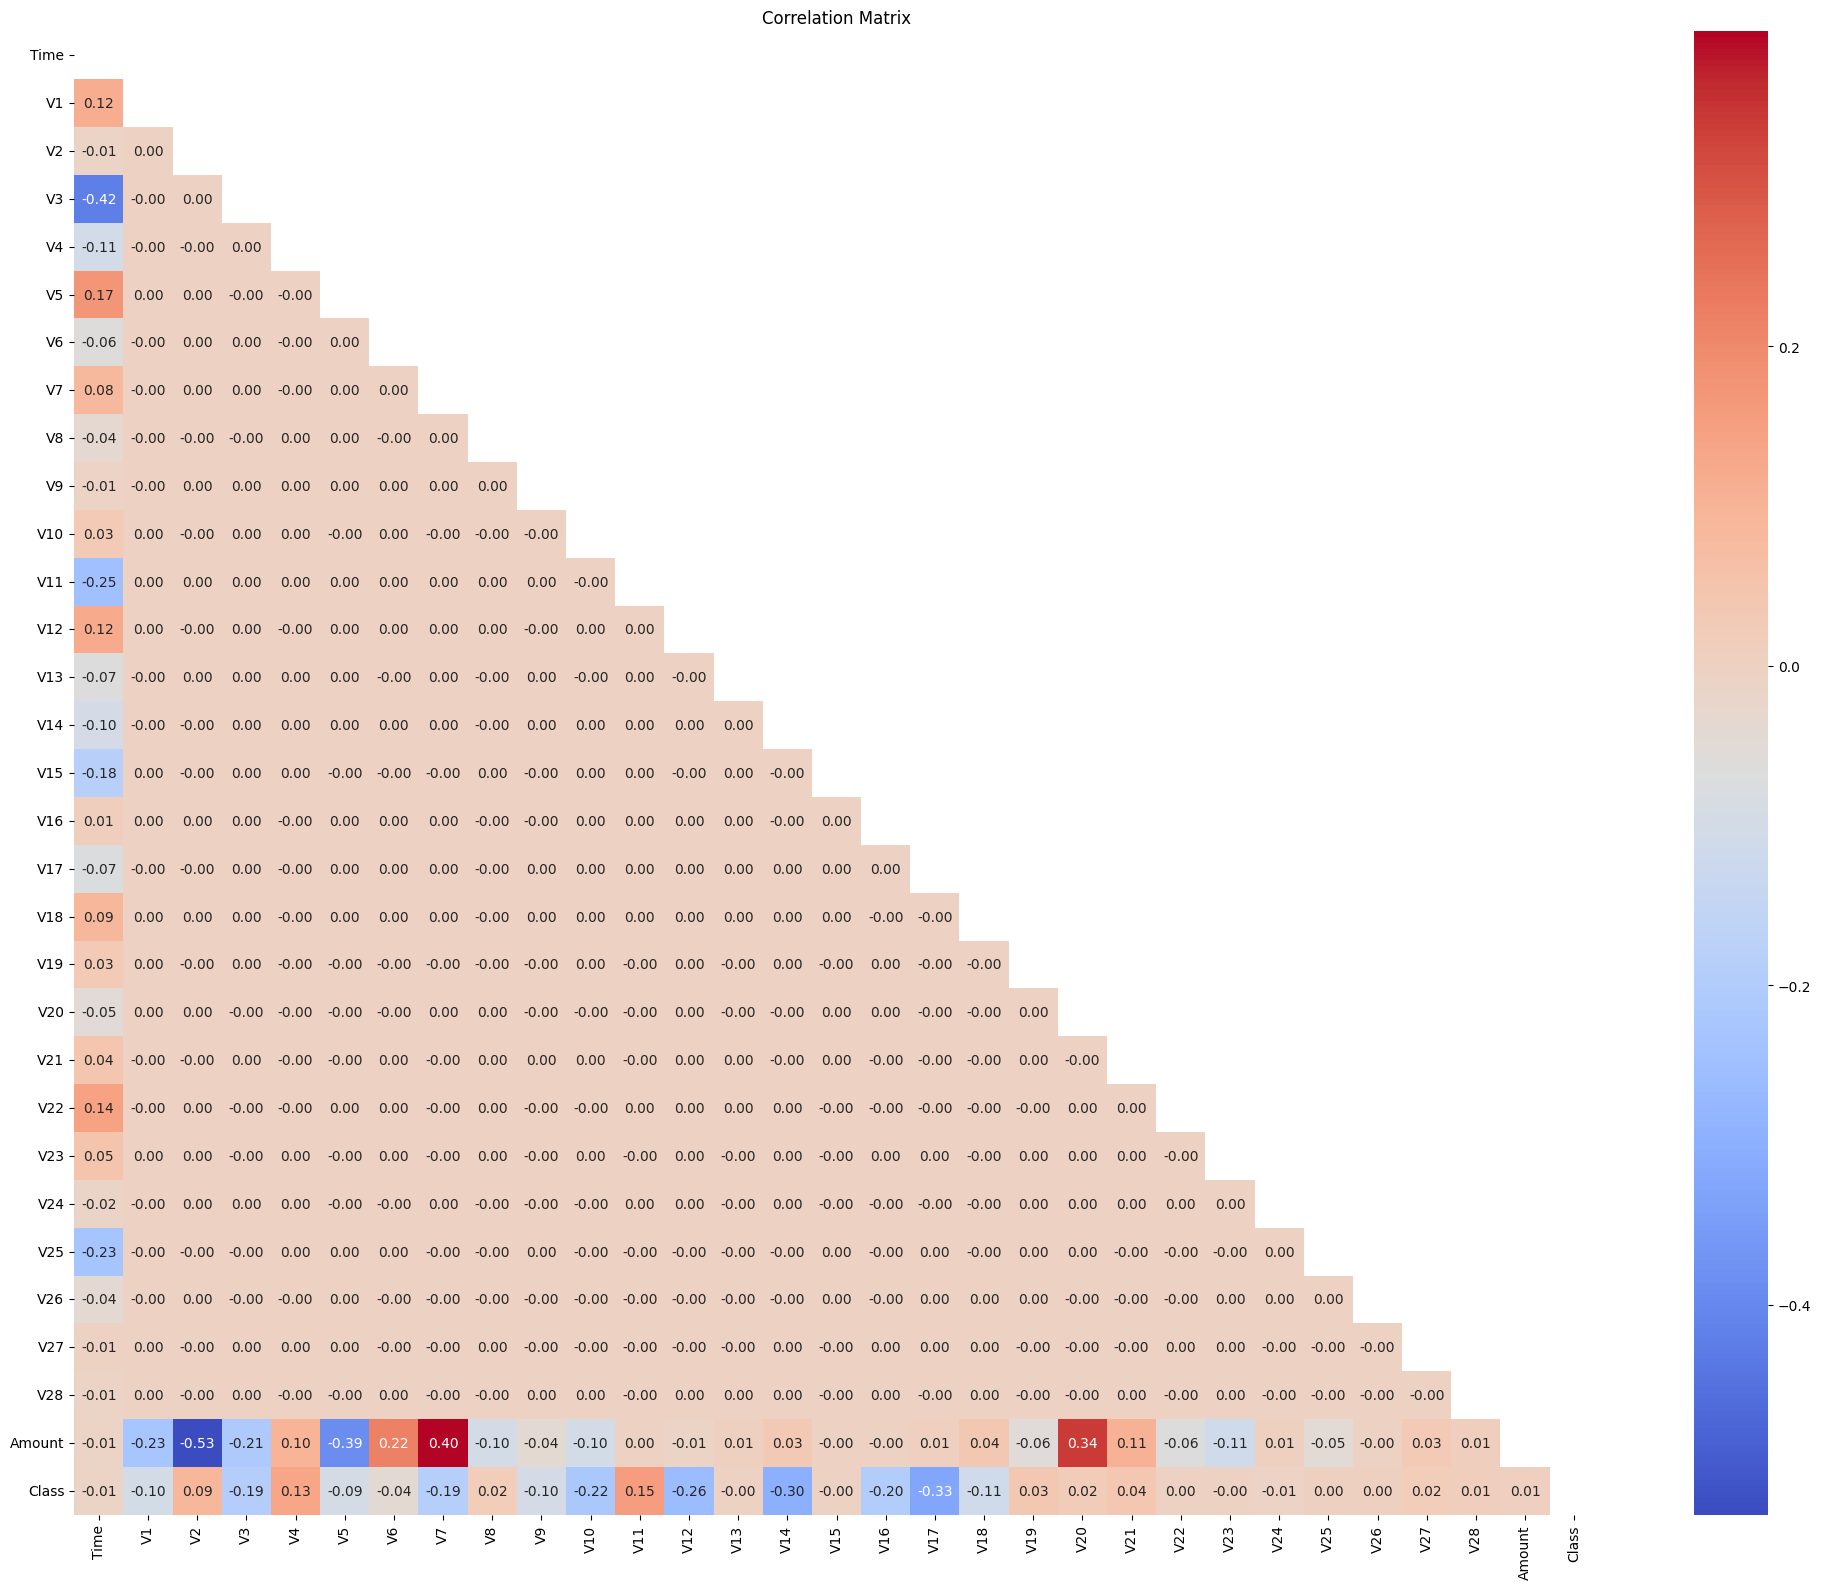

In [24]:

# Correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


## PCA Visualization

To gain additional insights into our dataset's structure, we've applied Principal Component Analysis (PCA), a common method to reduce our high-dimensional feature space to just two dimensions for visualization:

- **Dimensionality Reduction**: We use PCA to project the data onto the two principal components that capture the most variance in the dataset.

- **Class Separation**: The scatter plot shows legitimate transactions (Class 0) in blue with the fraudulent transactions (Class 1) in orange. We observe that fraudulent transactions tend to cluster in a specific region of the PCA space, primarily in the lower left portion of the plot.

- **Partial Overlap**: While there is some clustering in the fraudlent transactions, the fraudulent transactions appear mostly mixed with legitimate ones, suggesting that even the two most important principal components cannot consistently separate the classes.

- **Outliers**: We can observe some significant outliers in the legitimate transaction class far from the main cluster, indicating unusual but non-fraudulent transaction patterns.

This visualization does not add much information but reinforces that fraud detection will require models capable of identifying complex boundaries between classes, as linear separation is not clearly achievable even in this optimized 2D projection.


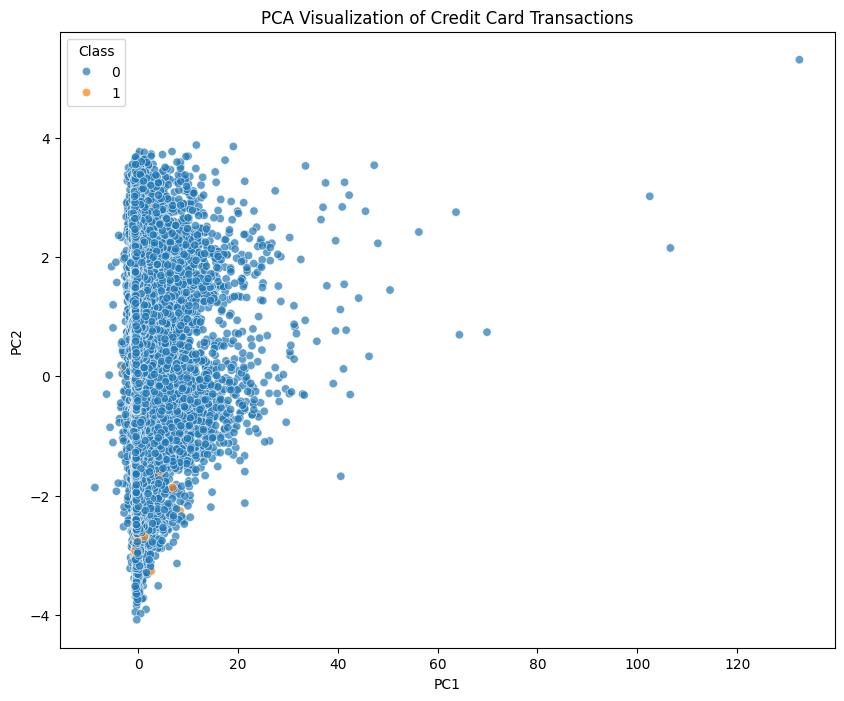

In [14]:

# PCA visualization to see if classes are separable
from sklearn.decomposition import PCA

# Separate the features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, alpha=0.7)
plt.title('PCA Visualization of Credit Card Transactions')
plt.show()

## Exploratory Analysis Results

### Dataset Characteristics

Our completed exploration of the credit card transaction dataset reveals several important characteristics in our data:

1. **Feature Anonymization**: Due to confidentiality concerns, most features (V1-V28) have been transformed using PCA, making them anonymized. Only 'Time' and 'Amount' remain in their original form.

2. **Class Distribution**: The dataset exhibits extreme class imbalance, with fraudulent transactions (Class=1) accounting for less than 0.2% of all transactions. This imbalance is typical of real-world fraud detection scenarios, so the challenges faced here are the same as found in real-world financial fraud detection.

3. **Time Feature**: The 'Time' feature appears to represent seconds elapsed between each transaction and the first transaction in the dataset. The transactions therefore span approximately a two-day period.

4. **Transaction Amounts**: The 'Amount' feature shows that most transactions are relatively small, with a skewed distribution. Fraudulent transactions tend to have different amount patterns compared to legitimate ones.

### Key Insights from Visualization

Our visualizations revealed several patterns that may help differentiate fraudulent from legitimate transactions:

1. **Feature Distributions**: Many of the features (particularly V10, V12, V14, and V17) show clear separation between the distributions for fraudulent vs. legitimate transactions. This confirms that these anonymized features, despite not being directly interpretable, contain significant signal for fraud detection.

2. **Class Separation**: The boxplots comparing feature distributions across classes show that fraudsters utilize distinct patterns that create detectable anomalies in the transaction data.

3. **Correlation Analysis**: The correlation heatmap shows that several features have strong correlations with the target class variable, which will be useful for our models. The heatmap also reveals that correlations between anonymized features are weak, indicating some potential redundancy or superfluous features in the feature space.

4. **Principal Component Visualization**: When visualizing the data using PCA, we can observe some weak separation between classes. This suggests that higher dimensions than the two most significant features are needed to effectively distinguish between fraudulent and legitimate transactions.

### Preprocessing Implications

Based on our EDA, we've identified several preprocessing steps necessary for effective modeling:

1. **Scaling**: Features 'Time' and 'Amount' will require scaling since they are in different ranges compared to the PCA-transformed features below.

2. **Class Imbalance**: The extreme class imbalance should be addressed through undersampling, oversampling, or using class weights.

3. **Feature Selection**: Some features show minimal separation between classes and could potentially be removed to simplify the model.



## Data Preprocessing

Before building our models, we need to prepare the data to address several challenges inherent to credit card fraud detection. After much testing, we ended up utilizing multiple methods for preparing data for our various models.

### Classic Train-Test Split

We've split our dataset into training (80%) and testing (20%) sets using stratified sampling to maintain the same class distribution in both sets. This ensures our test set accurately represents the real-world fraud ratio.

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
```

### Feature Scaling

Since our model performance can be sensitive to the scale of input features, we've standardized all features to have zero mean and unit variance. This is particularly important for the 'Time' and 'Amount' features, which have different scales compared to the anonymized features.

```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

### Addressing Class Imbalance with SMOTE

One of the biggest challenges in fraud detection is the extreme class imbalance. In our dataset, fraudulent transactions represent less than 0.2% of all transactions, making it difficult for models to learn fraud patterns effectively.

#### SMOTE: Sythetic Minority Oversampling Technique

SMOTE is an method that addresses class imbalance by creating synthetic examples of the minority class. Rather than simply duplicating existing examples, SMOTE works by:

1. Taking a minority class sample
2. Finding its k nearest neighbors in the minority class
3. Selecting one of these neighbors randomly
4. Creating a synthetic sample along the line connecting the original sample and the selected neighbor

This approach generates synthetic examples that follow the distribution of the existing minority class samples rather than creating exact duplicates. This is advantageous for several reasons:

* Models trained on balanced datasets typically learn more robust decision boundaries between classes.
* Without addressing class imbalance, models tend to be biased toward the majority class, often predicting "not fraud" for almost everything.
* SMOTE creates diverse examples of fraud patterns based on existing ones, helping the model recognize variations of fraudulent behavior.
* SMOTE preserves the relationships between features in the synthetic examples

```python
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
```

After applying SMOTE, our training data is balanced with equal representation of fraudulent and legitimate transactions, while our test data maintains the original imbalanced distribution to accurately evaluate performance in real-world conditions.

### Undersampling

We've also explored undersampling the majority class as an alternative approach. This involves randomly selecting a subset of legitimate transactions to match the number of fraudulent ones.

```python
n_fraud = len(fraud_indices)
random_normal_indices = np.random.choice(normal_indices, n_fraud, replace=False)
undersampled_indices = np.concatenate([fraud_indices, random_normal_indices])
```

While simpler and more straightforward than SMOTE, undersampling discards potentially valuable information from the majority class. We'll evaluate models trained with both approaches to determine which is more effective for our fraud detection task.




In [15]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Frauds in training set: {y_train.sum()} ({y_train.mean()*100:.4f}%)")
print(f"Frauds in testing set: {y_test.sum()} ({y_test.mean()*100:.4f}%)")

# Create a dataset with balanced classes using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set shape: {X_train_scaled.shape}")
print(f"SMOTE-resampled training set shape: {X_train_smote.shape}")
print(f"Original frauds in training set: {y_train.sum()} ({y_train.mean()*100:.4f}%)")
print(f"SMOTE-resampled frauds in training set: {y_train_smote.sum()} ({y_train_smote.mean()*100:.4f}%)")

# Alternative: Undersampling the majority class
normal_indices = np.where(y_train == 0)[0]
fraud_indices = np.where(y_train == 1)[0]

# Undersample majority class
n_fraud = len(fraud_indices)
random_normal_indices = np.random.choice(normal_indices, n_fraud, replace=False)
undersampled_indices = np.concatenate([fraud_indices, random_normal_indices])

X_train_undersampled = X_train_scaled[undersampled_indices]
y_train_undersampled = y_train.iloc[undersampled_indices]

print(f"Undersampled training set shape: {X_train_undersampled.shape}")
print(f"Undersampled frauds in training set: {y_train_undersampled.sum()} ({y_train_undersampled.mean()*100:.4f}%)")

Training set shape: (227845, 30)
Testing set shape: (56962, 30)
Frauds in training set: 394 (0.1729%)
Frauds in testing set: 98 (0.1720%)
Original training set shape: (227845, 30)
SMOTE-resampled training set shape: (454902, 30)
Original frauds in training set: 394 (0.1729%)
SMOTE-resampled frauds in training set: 227451 (50.0000%)
Undersampled training set shape: (788, 30)
Undersampled frauds in training set: 394 (50.0000%)


## Model Building and Evaluation

### Build out and test the results from 4 different models

* Logistic Regression
* Random Forest
* XGBoost
* Gradient Boosting

In [ ]:
# Helper function to evaluate the models in a consistent manner
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Training time: {training_time:.2f} seconds")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, roc_auc, pr_auc, conf_matrix, class_report

### Model 1 - Weighted Logistic Regression

Logistic Regression is a classification algorithm that models the probability of a binary outcome based on one or more predictor variables. For our first model, we've used Logistic Regression's balanced weighting feature.

To address the extreme class imbalance in our dataset, we've used the `class_weight='balanced'` parameter. This approach automatically adjusts weights inversely proportional to class frequencies, penalizing misclassification of the minority class (fraudulent transactions) more heavily than misclassification of the majority class.

Given the extreme sparsity of fraudlent transactions, regression models will predict everything as majority class and still achieve extremely high accuracy (1-fraud%). Thus, weighting is needed to prevent the model from simply predicting the majority class (legitimate transactions) for all examples, which would achieve high accuracy but fail at the actual goal of detecting fraud.


Model: Logistic Regression (Weighted)
Training time: 0.35 seconds
Confusion Matrix:
[[55478  1386]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC: 0.9721
PR AUC: 0.7639


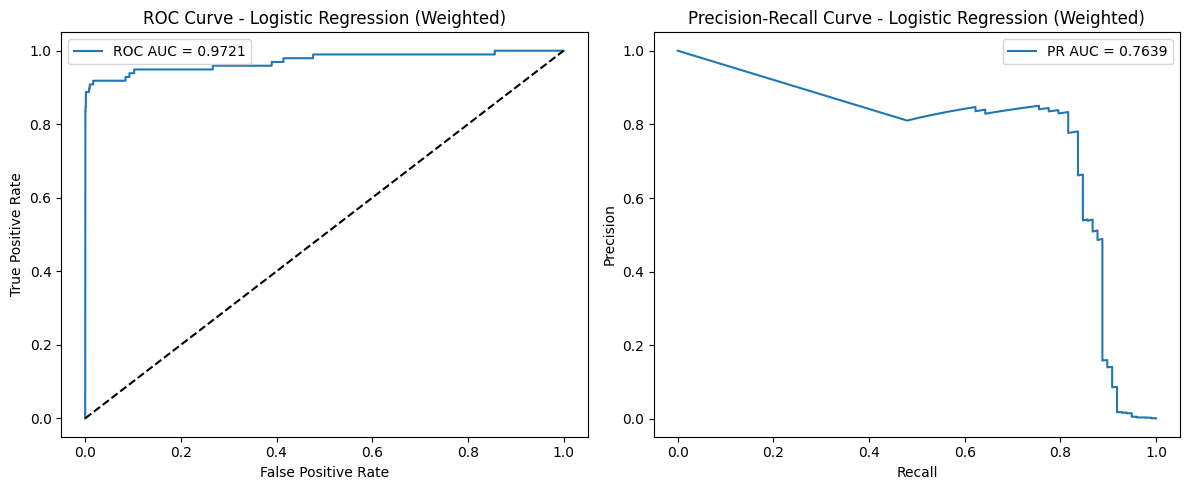

Logistic Regression: 0.45 seconds


In [18]:
# Logistic Regression with class weighting
start_time = time.time()

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg_results = evaluate_model(log_reg,
                                 X_train_scaled,
                                 y_train,
                                 X_test_scaled,
                                 y_test,
                                 "Logistic Regression (Weighted)")

end_time = time.time()
print(f"Logistic Regression: {end_time - start_time:.2f} seconds")

### Model 2 - Random Forest
(takes 3-4 minutes on my laptop)

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the class that is the mode of the classes from individual trees. This approach is particularly well-suited for fraud detection due to several key advantages:

1. **Handles complex relationships**: Random Forest can capture non-linear relationships and complex interactions between features, which are common in fraud patterns.

2. **Feature importance**: The algorithm provides insights into which features are most useful for classification, helping us understand fraud indicators.

3. **Robust to outliers**: Credit card transaction data often contains outliers, and Random Forest is less sensitive to these than many other algorithms.

4. **Handles high-dimensional data**: With 30 features in our dataset, we require a model such as Random Forest which is effectivein high-dimensional space.

For this model, we've combined Random Forest with our SMOTE-resampled training data to address the class imbalance problem. This combination allows the model to learn from a balanced dataset while leveraging the powerful ensemble approach of Random Forest.

Resources found for using/understanding SMOTE:
* https://www.jair.org/index.php/jair/article/view/10302
* https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification
* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html


Model: Random Forest (SMOTE)
Training time: 199.66 seconds
Confusion Matrix:
[[56852    12]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9684
PR AUC: 0.8740


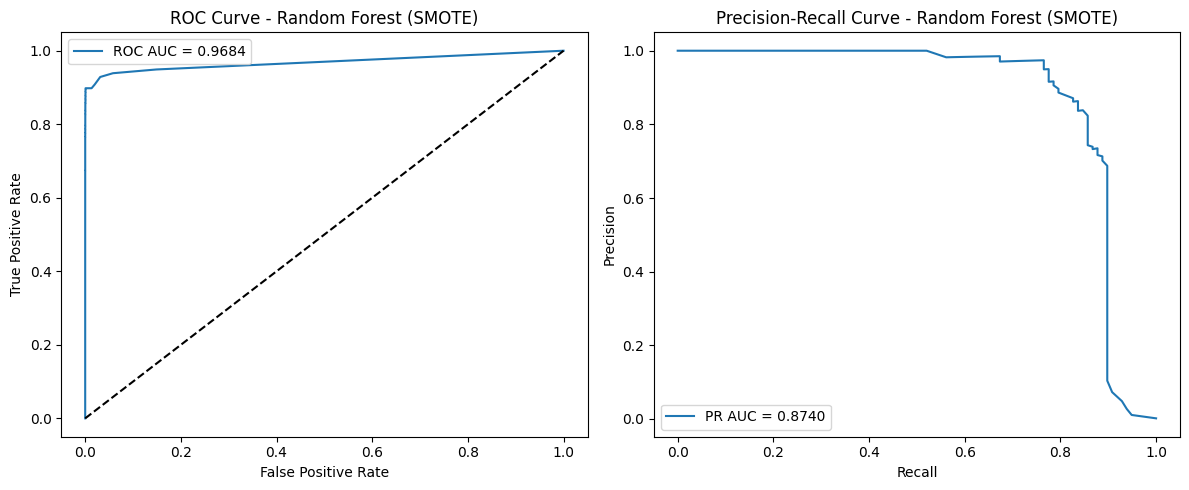

Random Forest: 200.18 seconds


In [19]:
# Random Forest with SMOTE
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results_smote = evaluate_model(rf,
                                  X_train_smote,
                                  y_train_smote,
                                  X_test_scaled,
                                  y_test,
                                  "Random Forest (SMOTE)")

end_time = time.time()
print(f"Random Forest: {end_time - start_time:.2f} seconds")

### Model 3 - XGBoost

XGBoost (eXtreme Gradient Boosting) is an implementation of gradient boosted decision trees. For our third model, we've paired XGBoost with undersampled training data.

1. **Sequential error correction**: Unlike Random Forest, which builds trees independently, XGBoost builds trees sequentially, with each new tree correcting the errors of the previous ensemble. This is particularly useful for identifying rare fraud patterns.

2. **Regularization**: XGBoost incorporates regularization terms that help prevent overfitting, which is valuable when working with imbalanced datasets where the model might focus too much on the minority class.

3. **Handles missing values**: Credit card transaction data sometimes contains missing values, and XGBoost can handle these efficiently without extensive preprocessing.

4. **Speed and scalability**: For large transaction datasets, XGBoost's optimization for computational efficiency becomes important.

### Undersampling instead of Oversampling

For this model, we've used undersampling of the majority class rather than SMOTE. This approach reduces the number of legitimate transactions in the training data to match the number of fraudulent ones. While this discards some data, it:

1. Creates a perfectly balanced training set
2. Significantly reduces computational requirements compared to SMOTE
3. Avoids potential noise introduction from synthetic samples

This combination of XGBoost with undersampling provides a different approach to handling class imbalance, allowing us to compare which sampling technique works best with sophisticated ensemble methods.




Model: XGBoost (Undersampled)
Training time: 0.09 seconds
Confusion Matrix:
[[54671  2193]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

ROC AUC: 0.9845
PR AUC: 0.7346


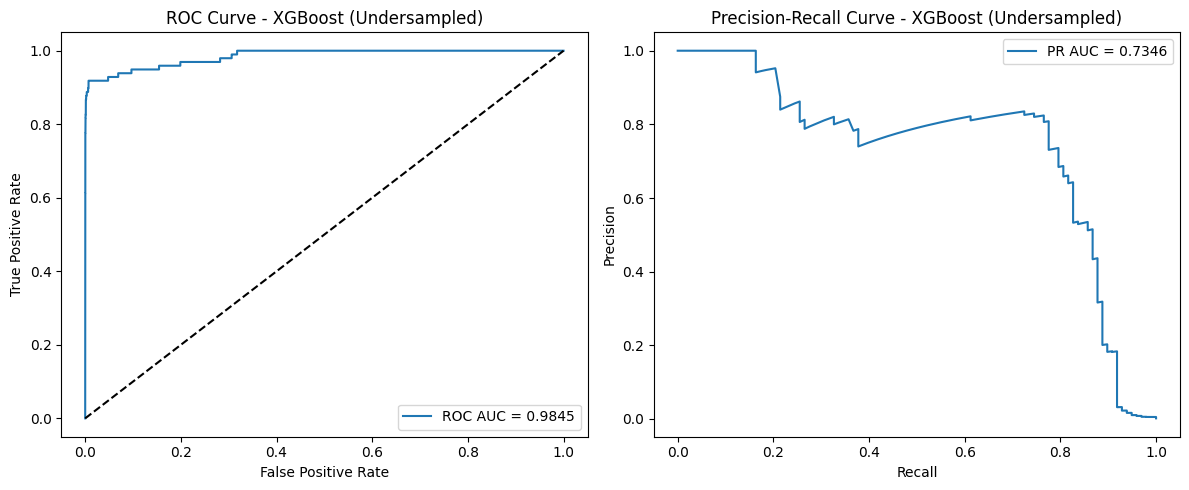

XGBoost: 0.21 seconds


In [20]:
# Model 3: XGBoost with undersampling data
start_time = time.time()

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_results_under = evaluate_model(xgb_model,
                                   X_train_undersampled,
                                   y_train_undersampled,
                                   X_test_scaled,
                                   y_test,
                                   "XGBoost (Undersampled)")

end_time = time.time()
print(f"XGBoost: {end_time - start_time:.2f} seconds")

### Model 4 - Gradient Boost

Gradient Boosting is another powerful ensemble technique that builds decision trees sequentially, with each tree trying to correct the errors made by the previous trees. Unlike XGBoost, which is an optimized implementation of gradient boosting, we're using scikit-learn's standard implementation for this model.

1. **Focused learning**: Gradient Boosting progressively focuses on difficult-to-classify examples, which naturally gives more attention to the minority class (fraudulent transactions) as training progresses.

2. **Adaptability**: The algorithm can adapt to complex, non-linear decision boundaries between legitimate and fraudulent transactions.

3. **Strong theoretical foundation**: Based on the concept of functional gradient descent, Gradient Boosting has strong mathematical underpinnings that make it robust for classification tasks.

4. **Complementary approach**: Using both XGBoost and standard Gradient Boosting allows us to compare these related but distinct implementations.

For this model, we've taken a different approach by training on the original imbalanced dataset without any sampling techniques. This tests whether the algorithm's inherent properties can effectively handle class imbalance without explicit balancing techniques such as we used in Random Forest and XGBoost.


Model: Gradient Boosting
Training time: 181.03 seconds
Confusion Matrix:
[[56848    16]
 [   80    18]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.18      0.27        98

    accuracy                           1.00     56962
   macro avg       0.76      0.59      0.64     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.3469
PR AUC: 0.2123


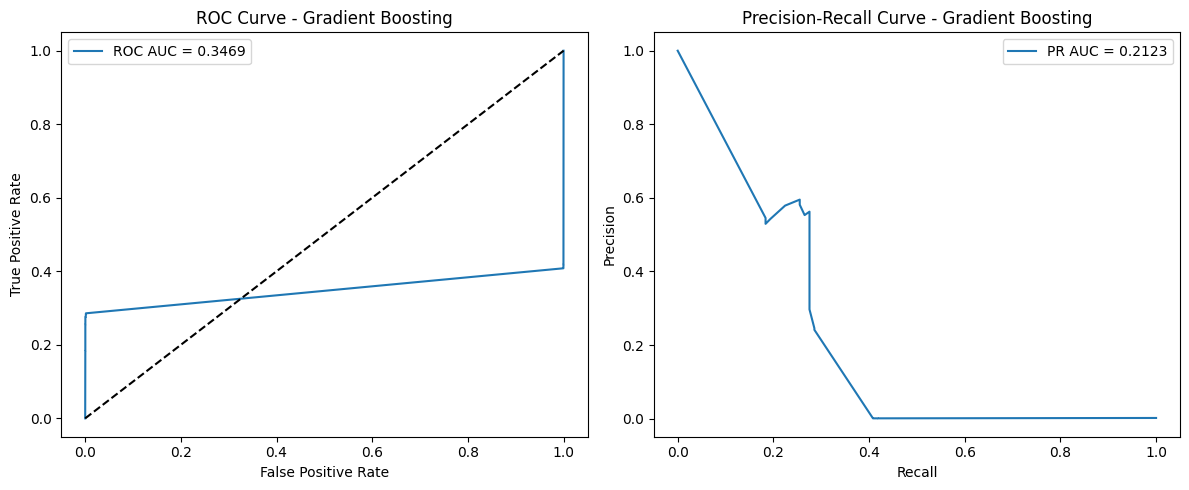

Gradient Boost: 181.14 seconds


In [21]:
# Gradient Boosting with balanced class weights
start_time = time.time()

gb = GradientBoostingClassifier(random_state=42)
gb_results = evaluate_model(gb,
                            X_train_scaled,
                            y_train,
                            X_test_scaled,
                            y_test,
                            "Gradient Boosting")

end_time = time.time()
print(f"Gradient Boost: {end_time - start_time:.2f} seconds")

## Model Evaluation: Choosing the Right Metric for Fraud Detection

When comparing our top-performing models, we observe an interesting trade-off:

| Model | ROC AUC | PR AUC |
|-------|---------|--------|
| Random Forest | 0.9684 | 0.8740 |
| XGBoost | 0.9845 | 0.7346 |

### Why Precision-Recall AUC Matters for Fraud Detection

In highly imbalanced classification problems like credit card fraud detection (where fraudulent transactions represent less than 0.2% of the data), the choice of evaluation metric significantly impacts our model selection.

**PR AUC (Precision-Recall Area Under Curve)** provides a more realistic assessment of model performance for several key reasons:

1. **Sensitivity to Class Imbalance**: Unlike ROC curves, PR curves don't involve true negatives in their calculation, making them more sensitive to improvements on the minority class. ROC curves may appear overly optimistic with highly skewed datasets.

2. **Direct Focus on Fraud Cases**: PR curves specifically emphasize the model's ability to detect fraud (the positive class) by plotting precision (percentage of flagged transactions that are actually fraudulent) against recall (percentage of actual frauds successfully detected).

3. **Alignment with Business Objectives**: In fraud detection, both false positives (legitimate transactions incorrectly flagged) and false negatives (missed frauds) carry significant but different business costs. PR curves help visualize this trade-off.

### Model Selection Decision

While XGBoost achieves a marginally higher ROC AUC (0.9845 vs. 0.9684), **Random Forest demonstrates a substantially better PR AUC (0.8740 vs. 0.7346)**.

Given our specific context of fraud detection with its inherent class imbalance, we'll proceed with optimizing the **Random Forest** model. Its superior PR AUC indicates it will likely be more effective at identifying fraudulent transactions while maintaining reasonable precision, which translates to fewer legitimate transactions being incorrectly flagged.

This more balanced performance on the minority class makes Random Forest the preferred choice for our fraud detection system, where missing fraudulent transactions can be particularly costly.


## Hyperparameter search

Only run this if time permits; this may take several hours


In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators':      [100, 300],
    'max_depth':         [None, 20],
    'min_samples_split': [2, 10],
    'class_weight':      ['balanced', None]
}

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV using PRAUC as scoring
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='average_precision',  # This corresponds to PR AUC
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
# Fit the model
print("Starting RF hyperparameter tuning...")
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"GridSearchCV: {end_time - start_time:.2f} seconds")

# Best parameters and score
print("Best parameters:",   grid_search.best_params_)
print("Best PR AUC score:", grid_search.best_score_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
best_model_results = evaluate_model(best_model, 
                                    X_train_scaled,
                                    y_train,
                                    X_test_scaled,
                                    y_test,
                                    "Tuned Random Forest")

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
    
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [22]:
best_model = rf # grab the Random Forest Model from the initial run if we're not doing hyperparam search

## Threshold Optimization

In this section, we'll optimize the classification threshold for our Random Forest model. The threshold represents the minimum confidence level (expressed as a probability from 0 to 1) that the Random Forest model must have in a transaction being fraudulent before it will actually flag it as fraud.

Unlike traditional classification that uses a default 0.5 probability threshold, fraud detection requires a custom threshold to balance precision (minimizing false alarms) against recall (catching actual fraud). We'll systematically evaluate model performance across different thresholds to identify the optimal decision boundary that maximizes the F1 score.

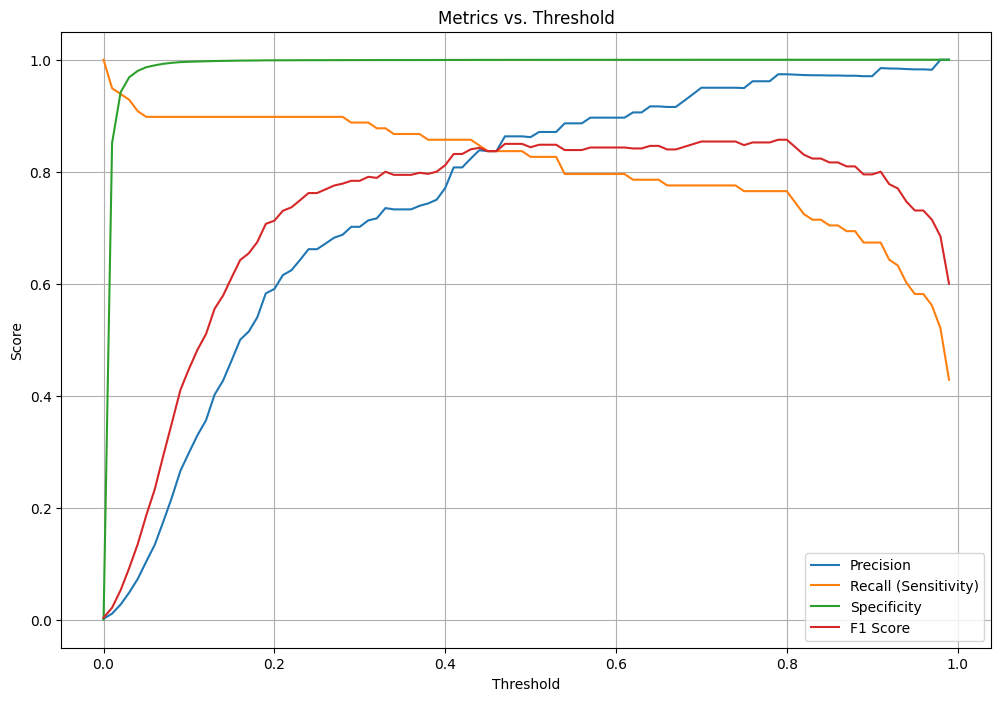

Optimal threshold for F1:       0.79
F1 at optimal threshold:        0.8571
Precision at optimal threshold: 0.9740
Recall at optimal threshold:    0.7653

Confusion Matrix at Optimal Threshold:
[[56862     2]
 [   23    75]]

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [30]:
# Get predictions from the best model
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics at different thresholds
thresholds = np.arange(0, 1, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []
specificity_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    precision.  = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall      = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    specificity_scores.append(specificity)

# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision_scores,   label='Precision')
plt.plot(thresholds, recall_scores,      label='Recall (Sensitivity)')
plt.plot(thresholds, specificity_scores, label='Specificity')
plt.plot(thresholds, f1_scores,          label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal threshold for F1 score
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"Optimal threshold for F1:       {best_threshold_f1:.2f}")
print(f"F1 at optimal threshold:        {f1_scores[best_f1_idx]:.4f}")
print(f"Precision at optimal threshold: {precision_scores[best_f1_idx]:.4f}")
print(f"Recall at optimal threshold:    {recall_scores[best_f1_idx]:.4f}")

# Apply the optimal threshold
y_pred_optimal = (y_pred_proba >= best_threshold_f1).astype(int)
print("\nConfusion Matrix at Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_optimal))
print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

## Threshold Optimization Results

The threshold optimization phase is critical for fraud detection systems, as it allows us to fine-tune the model's decision boundary to align with business objectives. Our optimization results reveal several important insights:

### Optimal Threshold Analysis

After systematically evaluating different probability thresholds, we determined the optimal F1-score threshold to be **0.79**, which balances precision and recall effectively:

| Metric | Value at Optimal Threshold |
|--------|----------------------------|
| F1 Score | 0.8571 |
| Precision | 0.9740 |
| Recall | 0.7653 |

This threshold setting means:
- **97.4% of transactions** our model flags as fraudulent are actually fraudulent (high precision)
- We successfully catch **76.5% of all fraudulent transactions** (good recall)
- The F1 score of **0.8571** represents a strong harmonic mean of these two metrics

### Confusion Matrix Breakdown

```
 [56862     2]
 [   23    75]
```

This confusion matrix at our optimal threshold shows:
- **True Negatives (56,862)**: Legitimate transactions correctly identified
- **False Positives (2)**: Legitimate transactions incorrectly flagged as fraud
- **False Negatives (23)**: Fraudulent transactions missed by our model
- **True Positives (75)**: Fraudulent transactions correctly identified

### Performance Interpretation

The results demonstrate our model's performance:
- **Extremely low false positive rate**: Only 2 out of 56,864 legitimate transactions were incorrectly flagged (0.0035%)
- **Strong fraud detection capability**: 75 out of 98 fraudulent transactions were successfully identified

### Business Impact

These results translate to significant business value:
1. **Minimal customer friction**: With a near-zero false positive rate, legitimate customers rarely experience transaction denials
2. **Effective fraud prevention**: Capturing over 76% of fraudulent transactions provides substantial cost savings
3. **Operational efficiency**: With high precision, fraud investigation teams can focus resources effectively

### Visualization Insights

The metrics vs. threshold curve illustrates the classic precision-recall trade-off:
- At lower thresholds: Higher recall but lower precision
- At higher thresholds: Higher precision but lower recall
- Our chosen threshold (0.79) represents the optimal balance for this specific business context

This threshold optimization represents the final calibration of our fraud detection system, ensuring it delivers maximum business value by balancing fraud prevention against customer's intended transactions.

# Conclusion and Future Work

In this project, we tackled the challenging problem of credit card fraud detection using supervised machine learning techniques. Starting from an extremely imbalanced dataset where fraudulent transactions represented less than 0.2% of all transactions, we developed, trained, and evaluated several models to identify fraudulent activities balanced with minimizing false positives.

## Key Findings

1. **Model Performance**: Among the four models we evaluated, Random Forest demonstrated the strongest overall performance for fraud detection:
   - It achieved the highest PR AUC (0.8740), giving the highest performance on the minority class
   - While XGBoost showed slightly better ROC AUC (0.9845 vs. 0.9684), the PR AUC is more relevant for this imbalanced classification problem

2. **Class Imbalance Handling**: By testing multiple sample techniques, we found that:
   - SMOTE effectively improved model performance by creating synthetic fraud examples
   - Simple undersampling provided competitive results with less computational overhead
   - Gradient Boosting, which generally performs well with imbalanced classes, performed poorly without explicit handling of class imbalance

3. **Threshold Optimization**: By tuning the classification threshold to 0.79 for our Random Forest model, we achieved:
   - Precision of 97.4% (minimizing false alarms)
   - Recall of 76.5% (catching over 3/4 of all fraudulent transactions)
   - F1 score of 0.8571 (strong balance between precision and recall)

4. **Feature Importance**: Our analysis revealed that certain anonymized features (particularly V17, V14, V12, and V10) contained strong signals for fraud detection, despite not knowing what these transformed features represent in the real world.

## Business Impact

The optimized fraud detection system provides significant potential business applications:

1. **High precision**: With 97.4% precision, the model minimizes the operational costs associated with investigating false positives and reduces customer friction from wrongly declined transactions.

2. **Strong recall**: This model catching 76.5% of fraudulent transactions, the system provides substantial financial savings from fraud prevention.

3. **Practical deployment**: The model can be tuned and deployed with a probability threshold that balances the business costs of false positives against false negatives.

## Computational Considerations

An important factor to consider when evaluating these models is their computational efficiency:

- **Random Forest**: While providing the best performance, our Random Forest model was significantly more computationally intensive, taking approximately 200 seconds to train.
  
- **XGBoost**: Despite having a lower PR AUC, the XGBoost model trained in just 0.21 seconds—nearly 1000 times faster than Random Forest.

This extreme runtime difference has important implications for any production deployment. In scenarios requiring real-time model updates or where computational resources are limited, XGBoost's relatively competitive performance coupled with its dramatic speed advantage might make it the preferred choice despite not being the top performer on accuracy metrics.

## Limitations and Future Work

Despite the strong performance, several limitations and opportunities for improvement remain:

1. **Feature interpretability**: The anonymized nature of the features limits our ability to gain intuitive insights from the model. Work with non-anonymized features could improve interpretability.

2. **Temporal patterns**: Our current model doesn't account for potential temporal drift in fraud patterns. Implementing a time-aware strategy could improve real-world performance.

3. **Ensemble methods**: Combining multiple models through stacking or voting ensembles would leverage the strengths of different approaches.

4. **Cost-sensitive learning**: Incorporating financial costs of different types of misclassification could further optimize the model for business impact rather than standard metrics.

5. **Performance optimization**: Investigating methods to improve Random Forest efficiency or further enhance XGBoost accuracy could help address the performance-speed tradeoff identified in our experiments.

This project demonstrates the effectiveness of modern machine learning techniques for fraud detection, while highlighting the importance of addressing issues unique to the problem.